In [ ]:
!pip install nba_api

In [203]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import time

In [204]:
nba_teams = teams.get_teams()
teams_df = pd.DataFrame(nba_teams)

In [205]:
# Helper function to avoid api rate limits
def safe_request(func, *args, **kwargs):
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)

def get_team_id(abbr):
    team = teams_df[teams_df['abbreviation'] == abbr.upper()]
    if not team.empty:
        return team.iloc[0]['id']
    else:
        raise ValueError(f"Team abbreviation '{abbr}' not found.")

def get_team_stats(team_id, n=5):
    log = safe_request(teamgamelog.TeamGameLog, team_id=team_id, season='2024-25')
    df = log.get_data_frames()[0]
    df = df[['GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']].copy()
    df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0)
    df['STREAK'] = df['WIN'].rolling(window=n).sum().shift(-1)
    df['STREAK'] = df['STREAK'].fillna(0)
    # avg stats from last 5 games
    rolling_features = ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']
    for col in rolling_features:
        df[f'{col}_AVG'] = df[col].rolling(window=n).mean().shift(-1)
    df = df.dropna().reset_index(drop=True)
    return df

In [206]:
all_team_dfs = []
for team in nba_teams:
    try:
        print(f"Loading {team['full_name']}...")
        team_data = get_team_stats(team['id'])
        team_data['Team'] = team['full_name']
        all_team_dfs.append(team_data)
        time.sleep(1.5)
    except Exception as e:
        print(f"Skipping {team['full_name']} due to error")

Loading Atlanta Hawks...
Loading Boston Celtics...
Loading Cleveland Cavaliers...
Loading New Orleans Pelicans...
Loading Chicago Bulls...
Loading Dallas Mavericks...
Loading Denver Nuggets...
Loading Golden State Warriors...
Loading Houston Rockets...
Loading Los Angeles Clippers...
Loading Los Angeles Lakers...
Loading Miami Heat...
Loading Milwaukee Bucks...
Loading Minnesota Timberwolves...
Loading Brooklyn Nets...
Loading New York Knicks...
Loading Orlando Magic...
Loading Indiana Pacers...
Loading Philadelphia 76ers...
Loading Phoenix Suns...
Loading Portland Trail Blazers...
Loading Sacramento Kings...
Loading San Antonio Spurs...
Loading Oklahoma City Thunder...
Loading Toronto Raptors...
Loading Utah Jazz...
Loading Memphis Grizzlies...
Loading Washington Wizards...
Loading Detroit Pistons...
Loading Charlotte Hornets...


In [207]:
df = pd.concat(all_team_dfs).reset_index(drop=True)
features = [f'{stat}_AVG' for stat in ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']] + ['STREAK']
X = df[features]
y = df['WIN']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [208]:
best_model = None
best_score = 0

rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)
if rf_grid.best_score_ > best_score:
    best_score = rf_grid.best_score_
    best_model = rf_grid.best_estimator_

gb_param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, scoring='accuracy')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting score:", gb_grid.best_score_)
if gb_grid.best_score_ > best_score:
    best_score = gb_grid.best_score_
    best_model = gb_grid.best_estimator_

Best Random Forest params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Random Forest score: 0.7120622568093385
Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting score: 0.7153047989623865


Model Accuracy: 0.74
Train Accuracy: 0.75
Test Accuracy:  0.74


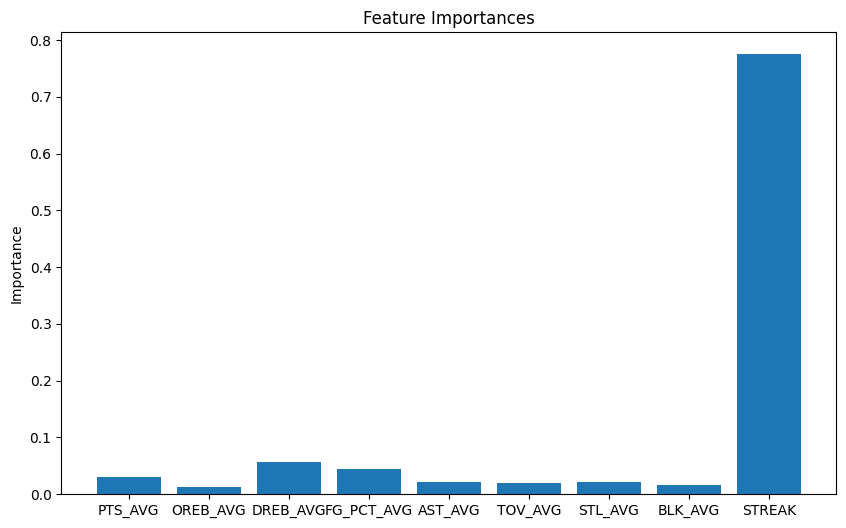

In [209]:
clf = best_model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")

importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

In [220]:
team1 = 'DAL'
team2 = 'LAC'

team1_id = get_team_id(team1)
team2_id = get_team_id(team2)

team1_data = get_team_stats(team1_id)
team2_data = get_team_stats(team2_id)

team1_input = team1_data.head(1)[features]
team2_input = team2_data.head(1)[features]

team1_proba = clf.predict_proba(team1_input)[0][1]
team2_proba = clf.predict_proba(team2_input)[0][1]

print(f"{team1} win probability: {team1_proba:.2f}")
print(f"{team2} win probability: {team2_proba:.2f}")
print(f"Predicted winner: {team1 if team1_proba > team2_proba else team2}\n")

# Estimate Over/Under (sum of last 5 avg PTS from both teams)
total_points_estimate = team1_input[f'PTS_AVG'].values[0] + team2_input[f'PTS_AVG'].values[0]
print(f"Estimated total points (Over/Under baseline): {total_points_estimate:.1f}")

# Potential spread (difference in predicted win probabilities)
spread_estimate = abs(team1_proba - team2_proba) * 10
print(f"Estimated spread: {spread_estimate:.1f}")

DAL win probability: 0.35
LAC win probability: 0.79
Predicted winner: LAC

Estimated total points (Over/Under baseline): 225.0
Estimated spread: 4.4
